# Indian Dance classifier

## Set up

In [ ]:
import pandas as pd
import os, shutil, pathlib
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow import keras
from tensorflow.keras import layers

## Loading and organising data

In [ ]:
catalog = pd.read_csv("/content/drive/MyDrive/dance/train.csv")
catalog.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [ ]:
catalog.target.value_counts()

mohiniyattam     50
odissi           49
bharatanatyam    47
kathakali        47
kuchipudi        46
sattriya         45
kathak           44
manipuri         36
Name: target, dtype: int64

In [ ]:
catalog.shape


(364, 2)

### Creating train, validation and test sets

In [ ]:
X = catalog.Image
y = catalog.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((261,), (66,), (37,))

In [ ]:
original_dir = pathlib.Path("/content/drive/MyDrive/dance/train")
new_base_dir = pathlib.Path("/content/drive/MyDrive/dance/data")

def make_subset(subset_name, X, y):
  for category in y.unique():
    indices = y[y == category].index
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    for i, fname in enumerate(X[indices]):
      new_fname = f"{category}.{i}.jpg"
      shutil.copyfile(src = original_dir / fname,
                      dst = dir / new_fname)
      
make_subset("train", X_train, y_train)
make_subset("validation", X_val, y_val)
make_subset("test", X_test, y_test)

In [ ]:
new_base_dir = pathlib.Path("/content/drive/MyDrive/dance/data")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 16
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 16
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 16
)

Found 261 files belonging to 8 classes.
Found 66 files belonging to 8 classes.
Found 37 files belonging to 8 classes.


## Initialising the pretrained model(VGG16)

In [ ]:
#instatiating the VGG 16 convolutional base
conv_base = keras.applications.vgg16.VGG16(weights = "imagenet",
                                          include_top = False,
                                          input_shape = (180,180,3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Lets's make the last two layers of VGG16 trainable for fine tuning

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-2]:
  layer.trainable = False

## Defining the model with keras functional API

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(8, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_28 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_28  (None, 180, 180, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_28 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 dense_73 (Dense)            (None, 5, 5, 256)         131

## Training

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="dance.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
17/17 [==============================] - 5s 119ms/step - loss: 9.8137 - accuracy: 0.2184 - val_loss: 4.3834 - val_accuracy: 0.3333
Epoch 2/50
17/17 [==============================] - 2s 107ms/step - loss: 2.2451 - accuracy: 0.4789 - val_loss: 2.7352 - val_accuracy: 0.4091
Epoch 3/50
17/17 [==============================] - 2s 95ms/step - loss: 1.3580 - accuracy: 0.6054 - val_loss: 2.9711 - val_accuracy: 0.4545
Epoch 4/50
17/17 [==============================] - 2s 93ms/step - loss: 1.1054 - accuracy: 0.6705 - val_loss: 3.3315 - val_accuracy: 0.4697
Epoch 5/50
17/17 [==============================] - 2s 95ms/step - loss: 0.7960 - accuracy: 0.7739 - val_loss: 2.9473 - val_accuracy: 0.4545
Epoch 6/50
17/17 [==============================] - 2s 96ms/step - loss: 0.6481 - accuracy: 0.8046 - val_loss: 3.9395 - val_accuracy: 0.4545
Epoch 7/50
17/17 [==============================] - 2s 108ms/step - loss: 0.5335 - accuracy: 0.8238 - val_loss: 2.4257 - val_accuracy: 0.5909
Epoch 8/50

## Evaluation

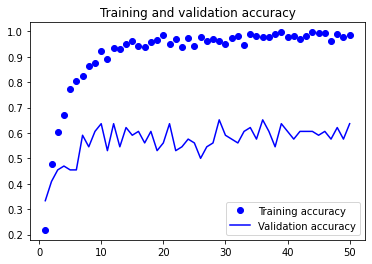

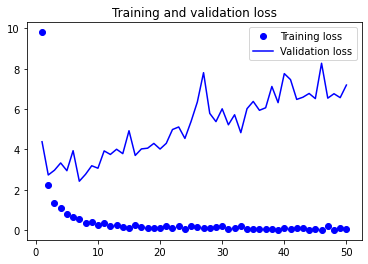

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("dance.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 0s 46ms/step - loss: 1.5438 - accuracy: 0.6757
Test accuracy: 0.676
